In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import rioxarray as rx
from tqdm import tqdm
import seaborn as sns 
import pandas as pd
import xarray as xr
from tqdm import trange, tqdm, tqdm_notebook
from shapely.geometry import Polygon
import cartopy

/home/chandra/.local/lib/python3.10/site-packages/xarray/backends/cfgrib_.py:29: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [2]:
import warnings
warnings.filterwarnings("ignore")

### Generating figure 1

In [3]:
Treecover = xr.open_dataset('/home/chandra/data/MOD44B_Treecover/0_360_res0.25/Treecover_MOD44B_2001-2012.nc').treecover
Treecover = Treecover.mean(axis = 0)

In [4]:
S_r = xr.open_mfdataset('/home/chandra/data/Max_RZSC_annual_Chirps_Ensemble(BESS+PML+FLUXCOM)/Simulation7 (Sensitivity dataset)/Ensemble/Max_Rootzone_20yearsreturn_Ensemble_(BESS+PML+FLUXCOM)_Chirps_0.25res_2001-2012_mle(skextremes).nc').mle_gumbel[0]

In [5]:
## Defining function to compute for each continent (based on lat and long values)

def ROIs(lat_top, lat_bottom, lon_min, lon_max):
    import xarray as xr
    import matplotlib.pyplot as plt
    global Landcover, Cropland, Pasture, Treecover
    global S_r, S_r_CI_lower, S_r_CI_upper
    global Ground_WT, eco_2017
    import numpy as np
    import pandas as pd
        
    S_r = {}; S_r_CI_lower = {}; S_r_CI_upper = {}
    '''
    Link to all the datasets below are are provided in the 'Data Availability' section of the manuscript
    '''
    #IGBP landcover classes
    Landcover = xr.open_dataset('/home/chandra/data/Landcover/IGBP/MCD12Q1_IGBP_Land_Classification_025res_2001_lonlatbox.nc').Band1.sel(lat = slice(-50,50))
    Landcover = Landcover.where((Landcover == 1) | (Landcover == 2) | (Landcover == 3) | (Landcover == 4) | (Landcover == 5) | (Landcover == 6) | 
               (Landcover == 7) | (Landcover == 8) | (Landcover == 9) | (Landcover == 10) | (Landcover == 12) | (Landcover == 14) | (Landcover == 16))
    
    #Ground water table depth
    Ground_WT = xr.open_dataset('/home/chandra/data/Water Table/Global_wtd_lowres_lontatbox_0.25res.nc').WTD[0].sel(lat = slice(-50,50))
    
    #MODIS continuous treecover
    Treecover = xr.open_dataset('/home/chandra/data/MOD44B_Treecover/0_360_res0.25/Treecover_MOD44B_2001-2012.nc').treecover;   
    
    #Foley et al (2005) cropland and pasture
    Cropland = xr.open_dataset('/home/chandra/data/Landcover/Crop and Pasture Area 2000/Python_interpolation/Cropland_ramakutty_2000_0.25res_lonlatbox.nc').Treecover.sel(lat = slice(-50,50))[0]
    Pasture = xr.open_dataset('/home/chandra/data/Landcover/Crop and Pasture Area 2000/Python_interpolation/Pasture_ramakutty_2000_0.25res_lonlatbox.nc').Treecover.sel(lat = slice(-50,50))[0]
    
    #Ecoregions
    #eco_2017 = xr.open_dataset('Ecoregions2017_lonlatbox.nc').Ecoregions2017[::-1,:].sel(lat = slice(-50,50))
    
    ## Select from defined lon and lat
    #eco_2017 = eco_2017.sel(lat = slice(lat_bottom,lat_top), lon = slice(lon_min,lon_max))
    Landcover = Landcover.sel(lat = slice(lat_bottom,lat_top), lon = slice(lon_min,lon_max))
    Cropland = Cropland.sel(lat = slice(lat_bottom,lat_top), lon = slice(lon_min,lon_max-0.01))
    Pasture = Pasture.sel(lat = slice(lat_bottom,lat_top), lon = slice(lon_min,lon_max-0.01))
    
    Treecover = Treecover.sel(lat = slice(lat_bottom,lat_top), lon = slice(lon_min,lon_max))    
    Ground_WT = Ground_WT.sel(lat = slice(lat_bottom,lat_top), lon = slice(lon_min,lon_max))    
    
    # Cropland and pasture threshold (30%)
    Threshold = 0.3
    '''
    Change threshold to 1 when running for transect #5 and #6; for the rest the threshold remains 0.3 (as 30% cropland & pasture filtering)
    '''
    Landcover = Landcover.where((Cropland.values < Threshold) & (Pasture.values < Threshold))
    Treecover = Treecover.where(Landcover.values>0)   
    
    #Rootzone storage capacity
    for return_period in [10,20,40]:
        S_r[str(return_period)] = xr.open_dataset('/home/chandra/data/Max_RZSC_annual_Chirps_Ensemble(BESS+PML+FLUXCOM)/Simulation9 (Return_period)/Max_Rootzone_'+str(return_period)+'yearsreturn_Ensemble_(BESS+PML+FLUXCOM)_Chirps_0.25res_2001-2012_mle(skextremes).nc').mle_gumbel[0]
        S_r[str(return_period)] = S_r[str(return_period)].sel(lat = slice(lat_bottom,lat_top), lon = slice(lon_min,lon_max))        
        S_r[str(return_period)] = S_r[str(return_period)].where(Landcover.values>0)
    
    for return_period in [10,20,40]:
        S_r_CI_lower[str(return_period)] = xr.open_dataset('/home/chandra/data/Max_RZSC_annual_Chirps_Ensemble(BESS+PML+FLUXCOM)/Simulation9 (Return_period)/Max_Rootzone_'+str(return_period)+'yearsreturn_Ensemble_(BESS+PML+FLUXCOM)_Chirps_0.25res_2001-2012_mle(skextremes)_CI_0.05_lower.nc').mle_gumbel_CI_lower[0]
        S_r_CI_upper[str(return_period)] = xr.open_dataset('/home/chandra/data/Max_RZSC_annual_Chirps_Ensemble(BESS+PML+FLUXCOM)/Simulation9 (Return_period)/Max_Rootzone_'+str(return_period)+'yearsreturn_Ensemble_(BESS+PML+FLUXCOM)_Chirps_0.25res_2001-2012_mle(skextremes)_CI_0.05_upper.nc').mle_gumbel_CI_upper[0]
        S_r_CI_lower[str(return_period)] = S_r_CI_lower[str(return_period)].sel(lat = slice(lat_bottom,lat_top), lon = slice(lon_min,lon_max))
        S_r_CI_upper[str(return_period)] = S_r_CI_upper[str(return_period)].sel(lat = slice(lat_bottom,lat_top), lon = slice(lon_min,lon_max))
        S_r_CI_lower[str(return_period)] =S_r_CI_lower[str(return_period)].where(Landcover.values>0)
        S_r_CI_upper[str(return_period)] =S_r_CI_upper[str(return_period)].where(Landcover.values>0)


In [6]:
# Calculating for South America
ROIs(15,-50,280,325)

In [7]:
for return_period in [10,20,40]:
    S_r[str(return_period)] = S_r[str(return_period)].rename({'lon': 'x','lat': 'y'})
    S_r[str(return_period)] = S_r[str(return_period)].assign_coords(x=(((S_r[str(return_period)].x - 180) % 360) - 179.875))

    S_r_CI_lower[str(return_period)] = S_r_CI_lower[str(return_period)].rename({'lon': 'x','lat': 'y'})
    S_r_CI_lower[str(return_period)] = S_r_CI_lower[str(return_period)].assign_coords(x=(((S_r_CI_lower[str(return_period)].x - 180) % 360) - 179.875))

    S_r_CI_upper[str(return_period)] = S_r_CI_upper[str(return_period)].rename({'lon': 'x','lat': 'y'})
    S_r_CI_upper[str(return_period)] = S_r_CI_upper[str(return_period)].assign_coords(x=(((S_r_CI_upper[str(return_period)].x - 180) % 360) - 179.875))

In [8]:
Treecover = Treecover.rename({'lon': 'x','lat': 'y'})
Treecover = Treecover.assign_coords(x=(((Treecover.x - 180) % 360) - 179.875))

In [46]:
import rioxarray as rx

#Transects 1 and 2 respectively
geometries_1 = [
    {
        'type': 'Polygon',
        'coordinates': [[
        [-77.5, -1.2500950457702227],
          [-35.53471347676384, -6.21052129709212],
          [-35.27104160176384, -4.497521499969107],
          [-77.5, 0.41972388143469946]]]
        }
]

geometries_2 = [
    {
        'type': 'Polygon',
        'coordinates': [[
        [-61, -25.33574390357598],
          [-58.94243405948794, -25.25628091854183],
          [-67.44360593448794, 4.588358690038858],
          [-68.69829343448794, 4.3251667771037083]]]
    }
]

S_r_geometries_1 = {}; S_r_geometries_2 = {}
S_r_CI_lower_geometries_1 = {}; S_r_CI_lower_geometries_2 = {}
S_r_CI_upper_geometries_1 = {}; S_r_CI_upper_geometries_2 = {}

for return_period in [10,20,40]:
    S_r[str(return_period)] = S_r[str(return_period)].rio.set_crs("+init=epsg:4326")
    S_r_CI_lower[str(return_period)] = S_r_CI_lower[str(return_period)].rio.set_crs("+init=epsg:4326")
    S_r_CI_upper[str(return_period)] = S_r_CI_upper[str(return_period)].rio.set_crs("+init=epsg:4326")
    
    S_r_geometries_1[str(return_period)]  = S_r[str(return_period)].rio.clip(geometries_1, crs=4326)
    S_r_geometries_2[str(return_period)]  = S_r[str(return_period)].rio.clip(geometries_2, crs=4326)
    S_r_CI_lower_geometries_1[str(return_period)]  = S_r_CI_lower[str(return_period)].rio.clip(geometries_1, crs=4326)
    S_r_CI_lower_geometries_2[str(return_period)]  = S_r_CI_lower[str(return_period)].rio.clip(geometries_2, crs=4326)
    S_r_CI_upper_geometries_1[str(return_period)]  = S_r_CI_upper[str(return_period)].rio.clip(geometries_1, crs=4326)
    S_r_CI_upper_geometries_2[str(return_period)]  = S_r_CI_upper[str(return_period)].rio.clip(geometries_2, crs=4326)

Treecover = Treecover.rio.set_crs("+init=epsg:4326")

Treecover_geometries_1 = Treecover.rio.clip(geometries_1, Treecover.rio.crs)
Treecover_geometries_2 = Treecover.rio.clip(geometries_2, Treecover.rio.crs)

In [47]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

In [48]:
def numpy_interpolater(y):
    def nan_helper(y):
        """Helper to handle indices and logical indices of NaNs.

        Input:
            - y, 1d numpy array with possible NaNs
        Output:
            - nans, logical indices of NaNs
            - index, a function, with signature indices= index(logical_indices),
              to convert logical indices of NaNs to 'equivalent' indices
        Example:
            >>> # linear interpolation of NaNs
            >>> nans, x= nan_helper(y)
            >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
        """

        return np.isnan(y), lambda z: z.nonzero()[0]
    nans, x= nan_helper(y)
    y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    return y

### Generating Figure 2

In [49]:
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

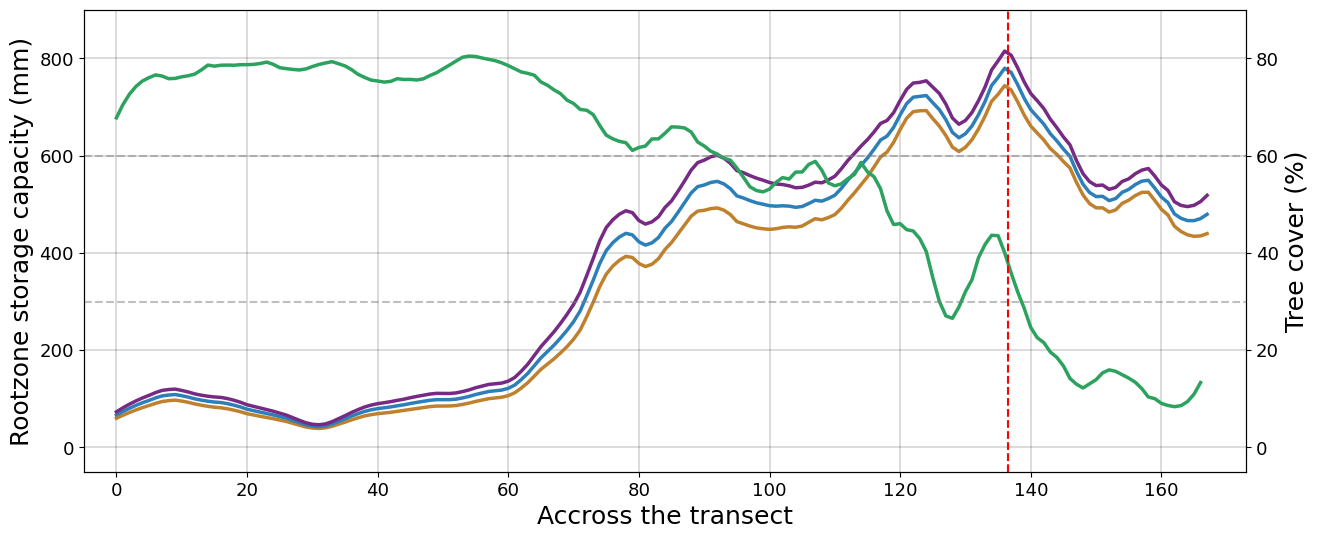

In [50]:
from scipy.signal import savgol_filter
import warnings
warnings.simplefilter("ignore")

fig, ax1 = plt.subplots(figsize = (15,6))
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

S_r_yhat = {}
for return_period, color in zip([10,20,40], ['#bf812d','#2c7fb8', '#762a83']):
    S_r_yhat[str(return_period)] = savgol_filter(S_r_geometries_1[str(return_period)].mean(axis = 0), 11, 2)
    S_r_yhat[str(return_period)] = numpy_interpolater(S_r_yhat[str(return_period)])
    #q1 = ax1.fill_between(np.linspace(0,S_r_yhat[str(return_period)].shape[0]-1,S_r_yhat[str(return_period)].shape[0]), S_r_CI_lower_geometries_1[str(return_period)].mean(axis = 0), 
    #                      S_r_CI_upper_geometries_1[str(return_period)].mean(axis = 0), color = color, alpha = 0.35)
    ax1.set_xlim(-5,S_r_yhat[str(return_period)].shape[0]-1+6)
    p1, = ax1.plot(S_r_yhat[str(return_period)], linewidth = 2.5, label = 'Rootzone Storage Capacity (mm)', color = color)

Treecover_yhat = savgol_filter(Treecover_geometries_1[0:12].mean(axis = 0).mean(axis = 0)[2:], 11, 3) 
#Treecover_yhat = savgol_filter(Treecover_geometries_1[11].mean(axis = 0), 11, 2) 
Treecover_yhat = numpy_interpolater(Treecover_yhat)
#upperlimit_yhat = ((Treecover_yhat +  (Treecover_geometries_1[0:12].where(Treecover_geometries_1).std(axis = 0).mean(axis = 0))*2))
#lowerlimit_yhat = ((Treecover_yhat -  (Treecover_geometries_1[0:12].where(Treecover_geometries_1).std(axis = 0).mean(axis = 0))*2))
#q2 = ax2.fill_between(np.linspace(0,S_r_yhat[str(return_period)].shape[0],S_r_yhat[str(return_period)].shape[0]+1), 
#                          upperlimit_yhat, lowerlimit_yhat, facecolor = '#2ca25f', alpha = 0.35)    
p2, = ax2.plot(Treecover_yhat, linewidth = 2.5, label = 'Treecover (%)', color = '#2ca25f')


ax1.set_xlabel('Accross the transect', fontsize = 18)
ax1.tick_params(axis='both', which='major', labelsize=13)
ax2.tick_params(axis='both', which='major', labelsize=13)
ax1.set_ylabel('Rootzone storage capacity (mm)', fontsize = 18)
ax2.set_ylabel('Tree cover (%)', fontsize = 18)
ax1.set_ylim(-50,900)
ax2.set_ylim(-5,90)


lines = [p1, p2]

ax1.grid(color='black', linestyle='-', linewidth=0.25, alpha=0.8)
ax2.axhline(y=60, linestyle='--', color = 'grey', alpha = 0.5)
ax2.axhline(y=30, linestyle='--', color = 'grey', alpha = 0.5)
ax2.axvline(x=136.5, linestyle='--', color = 'r')


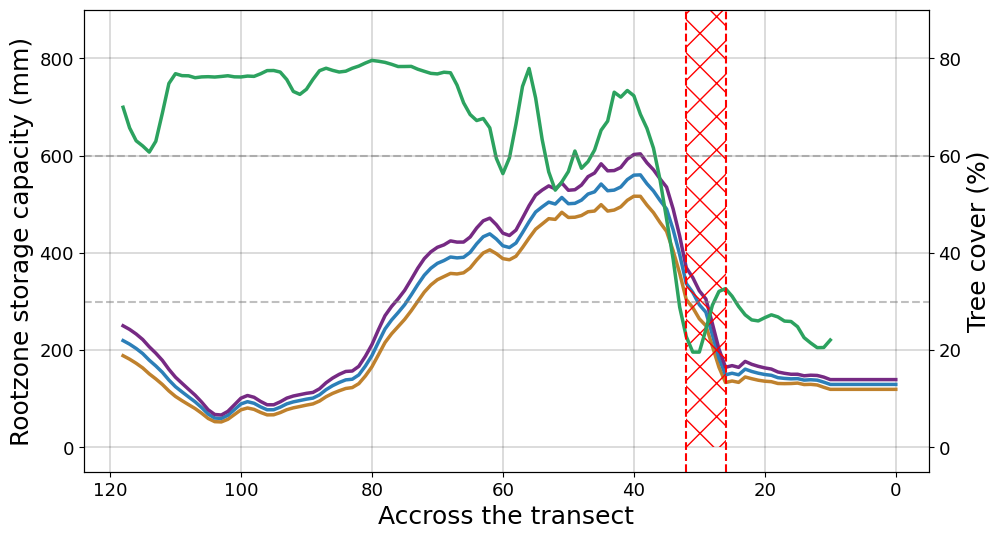

In [57]:
fig, ax1 = plt.subplots(figsize = (10.9,6))
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

S_r_yhat = {}
for return_period, color in zip([10,20,40], ['#bf812d','#2c7fb8', '#762a83']):
    S_r_yhat[str(return_period)] = savgol_filter(S_r_geometries_2[str(return_period)].mean(axis = 1), 7, 2)
    S_r_yhat[str(return_period)] = numpy_interpolater(S_r_yhat[str(return_period)])
    #q1 = ax1.fill_between(np.linspace(0,S_r_yhat[str(return_period)].shape[0]-1,S_r_yhat[str(return_period)].shape[0]), S_r_CI_lower_geometries_2[str(return_period)].mean(axis = 1), 
    #                      S_r_CI_upper_geometries_2[str(return_period)].mean(axis = 1), color = color, alpha = 0.35)
    ax1.set_xlim(-5,S_r_yhat[str(return_period)].shape[0]-1+6)
    p1, = ax1.plot(S_r_yhat[str(return_period)], linewidth = 2.5, label = 'Rootzone Storage Capacity (mm)', color = color)

Treecover_yhat = savgol_filter(Treecover_geometries_2[0:12].mean(axis = 0).mean(axis = 1), 7, 2)
p2, = ax2.plot(Treecover_yhat, linewidth = 2.5, label = 'Treecover (%)', color = '#2ca25f')

ax1.set_xlabel('Accross the transect', fontsize = 18)
ax1.tick_params(axis='both', which='major', labelsize=13)
ax2.tick_params(axis='both', which='major', labelsize=13)
ax1.set_ylabel('Rootzone storage capacity (mm)', fontsize = 18)
ax2.set_ylabel('Tree cover (%)', fontsize = 18)
ax1.set_ylim(-50,900)

ax2.set_ylim(-5,90)

lines = [p1, p2]#, p3]

ax1.grid(color='black', linestyle='-', linewidth=0.25, alpha=0.8)
ax2.axhline(y=60, linestyle='--', color = 'grey', alpha = 0.5)
ax2.axhline(y=30, linestyle='--', color = 'grey', alpha = 0.5)

ax2.axvline(x=26, linestyle='--', color = 'r')
ax2.axvline(x=32, linestyle='--', color = 'r')
plt.fill_between([26,32],[900,900], facecolor="none", hatch="X", edgecolor="r", linewidth=0.0)
#ax1.barh(-3, height=-45, align='edge', width=1,  left=np.arange(0, len(Ecozone)-1), color=color_sel)
plt.gca().invert_xaxis()

In [80]:
## For Africa
ROIs(15,-35,0,50) #For whole Africa

In [81]:
geometries_1 = [
    {
        'type': 'Polygon',
        'coordinates': 
        [[[8.834936327700573, 5.21556099844131],
          [27.90720195270057, -3.0484143188460475],
          [28.25876445270057, -1.9336534529331602],
          [9.450170702700573, 6.4022241987976685]]]}
]
geometries_2 = [
    {
        'type': 'Polygon',
        'coordinates': 
        [[[11.998998827700573, -4.828685101447719],
          [12.438451952700573, -6.016410639559621],
          [30.01657695270057, 1.4449573404359325],
          [29.66501445270057, 2.7231566959891853]]]}
]
geometries_3 = [
    {
        'type': 'Polygon',
        'coordinates': 
        [[[26.73142070270057, 0.2632440793744436],
          [25.67673320270057, -32.753139295483777],
          [27.29196757770057, -32.838494415868405],
          [28.34665507770057, 0.2632440793744436]]]}
]
geometries_4 = [
    {
        'type': 'Polygon',
        'coordinates': 
        [[[22.37009257770057, -3.382249861355598],
          [22.80954570270057, 14.93532802669767],
          [21.10642070270057, 14.861931638540655],
          [20.75485820270057, -3.3383801066004013]]]}
]

In [82]:
S_r_geometries_1 = {}; S_r_geometries_2 = {}; S_r_geometries_3 = {}; S_r_geometries_4 = {}
S_r_CI_lower_geometries_1 = {}; S_r_CI_lower_geometries_2 = {}; S_r_CI_lower_geometries_3 = {}; S_r_CI_lower_geometries_4 = {}
S_r_CI_upper_geometries_1 = {}; S_r_CI_upper_geometries_2 = {}; S_r_CI_upper_geometries_3 = {}; S_r_CI_upper_geometries_4 = {}

for return_period in [10,20,40]:
    S_r[str(return_period)] = S_r[str(return_period)].rename({'lon': 'x','lat': 'y'})
    S_r[str(return_period)] = S_r[str(return_period)].assign_coords(x=(((S_r[str(return_period)].x - 180) % 360) - 179.875))

    S_r[str(return_period)] = S_r[str(return_period)].rio.set_crs("+init=epsg:4326")

    S_r_geometries_1[str(return_period)] = S_r[str(return_period)].rio.clip(geometries_1, crs=4326)
    S_r_geometries_2[str(return_period)] = S_r[str(return_period)].rio.clip(geometries_2, crs=4326)
    S_r_geometries_3[str(return_period)] = S_r[str(return_period)].rio.clip(geometries_3, crs=4326)
    S_r_geometries_4[str(return_period)] = S_r[str(return_period)].rio.clip(geometries_4, crs=4326)
    
    S_r_CI_lower[str(return_period)] = S_r_CI_lower[str(return_period)].rename({'lon': 'x','lat': 'y'})
    S_r_CI_lower[str(return_period)] = S_r_CI_lower[str(return_period)].assign_coords(x=(((S_r_CI_lower[str(return_period)].x - 180) % 360) - 179.875))

    S_r_CI_upper[str(return_period)] = S_r_CI_upper[str(return_period)].rename({'lon': 'x','lat': 'y'})
    S_r_CI_upper[str(return_period)] = S_r_CI_upper[str(return_period)].assign_coords(x=(((S_r_CI_upper[str(return_period)].x - 180) % 360) - 179.875))

    S_r_CI_lower[str(return_period)] = S_r_CI_lower[str(return_period)].rio.set_crs("+init=epsg:4326")
    S_r_CI_upper[str(return_period)] = S_r_CI_upper[str(return_period)].rio.set_crs("+init=epsg:4326")
    
    S_r_CI_lower_geometries_1[str(return_period)] = S_r_CI_lower[str(return_period)].rio.clip(geometries_1, crs=4326)
    S_r_CI_lower_geometries_2[str(return_period)] = S_r_CI_lower[str(return_period)].rio.clip(geometries_2, crs=4326)
    S_r_CI_lower_geometries_3[str(return_period)] = S_r_CI_lower[str(return_period)].rio.clip(geometries_3, crs=4326)
    S_r_CI_lower_geometries_4[str(return_period)] = S_r_CI_lower[str(return_period)].rio.clip(geometries_4, crs=4326)
    S_r_CI_upper_geometries_1[str(return_period)] = S_r_CI_upper[str(return_period)].rio.clip(geometries_1, crs=4326)
    S_r_CI_upper_geometries_2[str(return_period)] = S_r_CI_upper[str(return_period)].rio.clip(geometries_2, crs=4326)
    S_r_CI_upper_geometries_3[str(return_period)] = S_r_CI_upper[str(return_period)].rio.clip(geometries_3, crs=4326)
    S_r_CI_upper_geometries_4[str(return_period)] = S_r_CI_upper[str(return_period)].rio.clip(geometries_4, crs=4326)

In [83]:
Treecover = Treecover.rename({'lon': 'x','lat': 'y'})
Treecover = Treecover.assign_coords(x=(((Treecover.x - 180) % 360) - 179.875))

In [84]:
Treecover = Treecover.rio.set_crs("+init=epsg:4326")
Treecover_geometries_1 = Treecover.rio.clip(geometries_1, Treecover.rio.crs)
Treecover_geometries_2 = Treecover.rio.clip(geometries_2, Treecover.rio.crs)
Treecover_geometries_3 = Treecover.rio.clip(geometries_3, Treecover.rio.crs)
Treecover_geometries_4 = Treecover.rio.clip(geometries_4, Treecover.rio.crs)


### Generating Figure 3

##### Transect #3

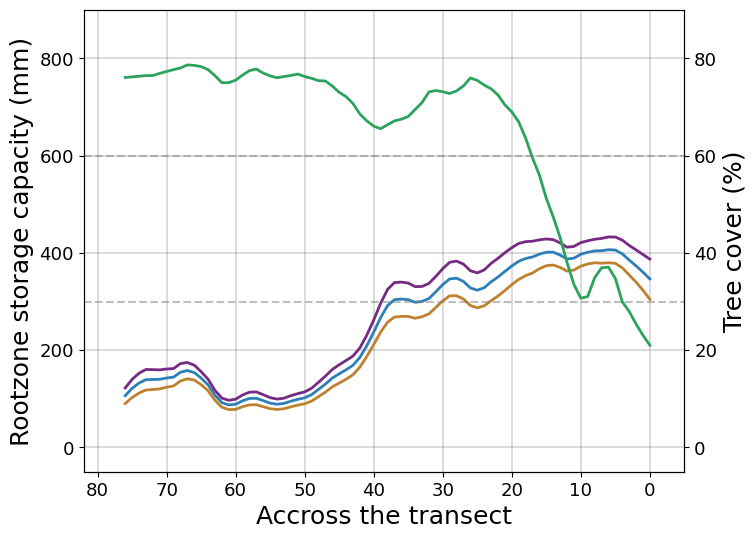

In [73]:
from scipy.signal import savgol_filter
import warnings
warnings.simplefilter("ignore")

fig, ax1 = plt.subplots(figsize = (7.75,6))
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

for return_period, color in zip([10,20,40], ['#bf812d','#2c7fb8', '#762a83']):
    S_r_yhat[str(return_period)] = savgol_filter(S_r_geometries_1[str(return_period)].mean(axis = 0), 7, 2)
    S_r_yhat[str(return_period)] = numpy_interpolater(S_r_yhat[str(return_period)])
    p1, = ax1.plot(S_r_yhat[str(return_period)], linewidth = 2, label = 'Rootzone Storage capacity (mm)', color = color)
    ax1.set_xlim(-5,S_r_yhat[str(return_period)].shape[0]-1+6)


Treecover_yhat = savgol_filter(Treecover_geometries_1[0:12].mean(axis = 0).mean(axis = 0), 7, 2) 
Treecover_yhat = numpy_interpolater(Treecover_yhat)

p2, = ax2.plot(Treecover_yhat, linewidth = 2, label = 'Treecover (%)', color = '#2ca25f')


ax1.set_xlabel('Accross the transect', fontsize = 18)
ax1.tick_params(axis='both', which='major', labelsize=13)
ax2.tick_params(axis='both', which='major', labelsize=13)
ax1.set_ylabel('Rootzone storage capacity (mm)', fontsize = 18)
ax2.set_ylabel('Tree cover (%)', fontsize = 18)
ax1.set_ylim(-50,900)

ax2.set_ylim(-5,90)
lines = [p1, p2]

#adds major gridlines
ax1.grid(color='black', linestyle='-', linewidth=0.25, alpha=0.8)
ax2.axhline(y=60, linestyle='--', color = 'grey', alpha = 0.5)
ax2.axhline(y=30, linestyle='--', color = 'grey', alpha = 0.5)
plt.gca().invert_xaxis()

##### Transect #4

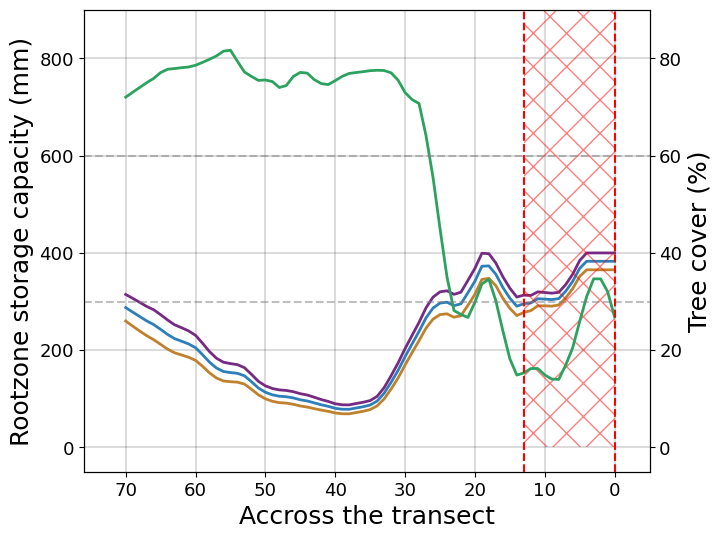

In [76]:
from scipy.signal import savgol_filter

fig, ax1 = plt.subplots(figsize = (7.3,6))
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

for return_period, color in zip([10,20,40], ['#bf812d','#2c7fb8', '#762a83']):
    S_r_yhat[str(return_period)] = savgol_filter(S_r_geometries_2[str(return_period)].mean(axis = 0), 7, 2)
    S_r_yhat[str(return_period)] = numpy_interpolater(S_r_yhat[str(return_period)])
    p1, = ax1.plot(S_r_yhat[str(return_period)], linewidth = 2, label = 'Rootzone Storage capacity (mm)', color = color)
    ax1.set_xlim(-5,S_r_yhat[str(return_period)].shape[0]-1+6)

Treecover_yhat = savgol_filter(Treecover_geometries_2[0:12].mean(axis = 0).mean(axis = 0), 7, 2) 
Treecover_yhat = numpy_interpolater(Treecover_yhat)


p2, = ax2.plot(Treecover_yhat, linewidth = 2, label = 'Treecover (%)', color = '#2ca25f')

ax1.set_xlabel('Accross the transect', fontsize = 18)
ax1.tick_params(axis='both', which='major', labelsize=13)
ax2.tick_params(axis='both', which='major', labelsize=13)
ax1.set_ylabel('Rootzone storage capacity (mm)', fontsize = 18)
ax2.set_ylabel('Tree cover (%)', fontsize = 18)
ax1.set_ylim(-50,900)

ax2.set_ylim(-5,90)

lines = [p1, p2]

ax1.grid(color='black', linestyle='-', linewidth=0.25, alpha=0.8)
ax2.axhline(y=60, linestyle='--', color = 'grey', alpha = 0.5)
ax2.axhline(y=30, linestyle='--', color = 'grey', alpha = 0.5)

plt.fill_between([0,13],[900,900], facecolor="none", hatch="X", edgecolor="r", linewidth=0.0, alpha = 0.5)

ax2.axvline(x=0, linestyle='--', color = 'r')
ax2.axvline(x=13, linestyle='--', color = 'r')

plt.gca().invert_xaxis()

In [79]:
## Defining function to compute for each continent (based on lat and long values)

def ROIs(lat_top, lat_bottom, lon_min, lon_max):
    import xarray as xr
    import matplotlib.pyplot as plt
    global Landcover, Cropland, Pasture, Treecover
    global S_r, S_r_CI_lower, S_r_CI_upper
    global Ground_WT, eco_2017
    import numpy as np
    import pandas as pd
        
    S_r = {}; S_r_CI_lower = {}; S_r_CI_upper = {}
    '''
    Link to all the datasets below are are provided in the 'Data Availability' section of the manuscript
    '''
    #IGBP landcover classes
    Landcover = xr.open_dataset('/home/chandra/data/Landcover/IGBP/MCD12Q1_IGBP_Land_Classification_025res_2001_lonlatbox.nc').Band1.sel(lat = slice(-50,50))
    Landcover = Landcover.where((Landcover == 1) | (Landcover == 2) | (Landcover == 3) | (Landcover == 4) | (Landcover == 5) | (Landcover == 6) | 
               (Landcover == 7) | (Landcover == 8) | (Landcover == 9) | (Landcover == 10) | (Landcover == 12) | (Landcover == 14) | (Landcover == 16))
    
    #Ground water table depth
    Ground_WT = xr.open_dataset('/home/chandra/data/Water Table/Global_wtd_lowres_lontatbox_0.25res.nc').WTD[0].sel(lat = slice(-50,50))
    
    #MODIS continuous treecover
    Treecover = xr.open_dataset('/home/chandra/data/MOD44B_Treecover/0_360_res0.25/Treecover_MOD44B_2001-2012.nc').treecover;   
    
    #Foley et al (2005) cropland and pasture
    Cropland = xr.open_dataset('/home/chandra/data/Landcover/Crop and Pasture Area 2000/Python_interpolation/Cropland_ramakutty_2000_0.25res_lonlatbox.nc').Treecover.sel(lat = slice(-50,50))[0]
    Pasture = xr.open_dataset('/home/chandra/data/Landcover/Crop and Pasture Area 2000/Python_interpolation/Pasture_ramakutty_2000_0.25res_lonlatbox.nc').Treecover.sel(lat = slice(-50,50))[0]
    
    #Ecoregions
    #eco_2017 = xr.open_dataset('Ecoregions2017_lonlatbox.nc').Ecoregions2017[::-1,:].sel(lat = slice(-50,50))
    
    ## Select from defined lon and lat
    #eco_2017 = eco_2017.sel(lat = slice(lat_bottom,lat_top), lon = slice(lon_min,lon_max))
    Landcover = Landcover.sel(lat = slice(lat_bottom,lat_top), lon = slice(lon_min,lon_max))
    Cropland = Cropland.sel(lat = slice(lat_bottom,lat_top), lon = slice(lon_min,lon_max-0.01))
    Pasture = Pasture.sel(lat = slice(lat_bottom,lat_top), lon = slice(lon_min,lon_max-0.01))
    
    Treecover = Treecover.sel(lat = slice(lat_bottom,lat_top), lon = slice(lon_min,lon_max))    
    Ground_WT = Ground_WT.sel(lat = slice(lat_bottom,lat_top), lon = slice(lon_min,lon_max))    
    
    # Cropland and pasture threshold (30%)
    Threshold = 0.3
    '''
    Change threshold to 1 when running for transect #5 and #6; for the rest the threshold remains 0.3 (as 30% cropland & pasture filtering)
    '''
    Landcover = Landcover.where((Cropland.values < Threshold) & (Pasture.values < Threshold))
    #Treecover = Treecover.where(Landcover.values>0)   
    
    #Rootzone storage capacity
    for return_period in [10,20,40]:
        S_r[str(return_period)] = xr.open_dataset('/home/chandra/data/Max_RZSC_annual_Chirps_Ensemble(BESS+PML+FLUXCOM)/Simulation9 (Return_period)/Max_Rootzone_'+str(return_period)+'yearsreturn_Ensemble_(BESS+PML+FLUXCOM)_Chirps_0.25res_2001-2012_mle(skextremes).nc').mle_gumbel[0]
        S_r[str(return_period)] = S_r[str(return_period)].sel(lat = slice(lat_bottom,lat_top), lon = slice(lon_min,lon_max))        
        #S_r[str(return_period)] = S_r[str(return_period)].where(Landcover.values>0)
    
    for return_period in [10,20,40]:
        S_r_CI_lower[str(return_period)] = xr.open_dataset('/home/chandra/data/Max_RZSC_annual_Chirps_Ensemble(BESS+PML+FLUXCOM)/Simulation9 (Return_period)/Max_Rootzone_'+str(return_period)+'yearsreturn_Ensemble_(BESS+PML+FLUXCOM)_Chirps_0.25res_2001-2012_mle(skextremes)_CI_0.05_lower.nc').mle_gumbel_CI_lower[0]
        S_r_CI_upper[str(return_period)] = xr.open_dataset('/home/chandra/data/Max_RZSC_annual_Chirps_Ensemble(BESS+PML+FLUXCOM)/Simulation9 (Return_period)/Max_Rootzone_'+str(return_period)+'yearsreturn_Ensemble_(BESS+PML+FLUXCOM)_Chirps_0.25res_2001-2012_mle(skextremes)_CI_0.05_upper.nc').mle_gumbel_CI_upper[0]
        S_r_CI_lower[str(return_period)] = S_r_CI_lower[str(return_period)].sel(lat = slice(lat_bottom,lat_top), lon = slice(lon_min,lon_max))
        S_r_CI_upper[str(return_period)] = S_r_CI_upper[str(return_period)].sel(lat = slice(lat_bottom,lat_top), lon = slice(lon_min,lon_max))
        #S_r_CI_lower[str(return_period)] =S_r_CI_lower[str(return_period)].where(Landcover.values>0)
        #S_r_CI_upper[str(return_period)] =S_r_CI_upper[str(return_period)].where(Landcover.values>0)


##### Transect #5

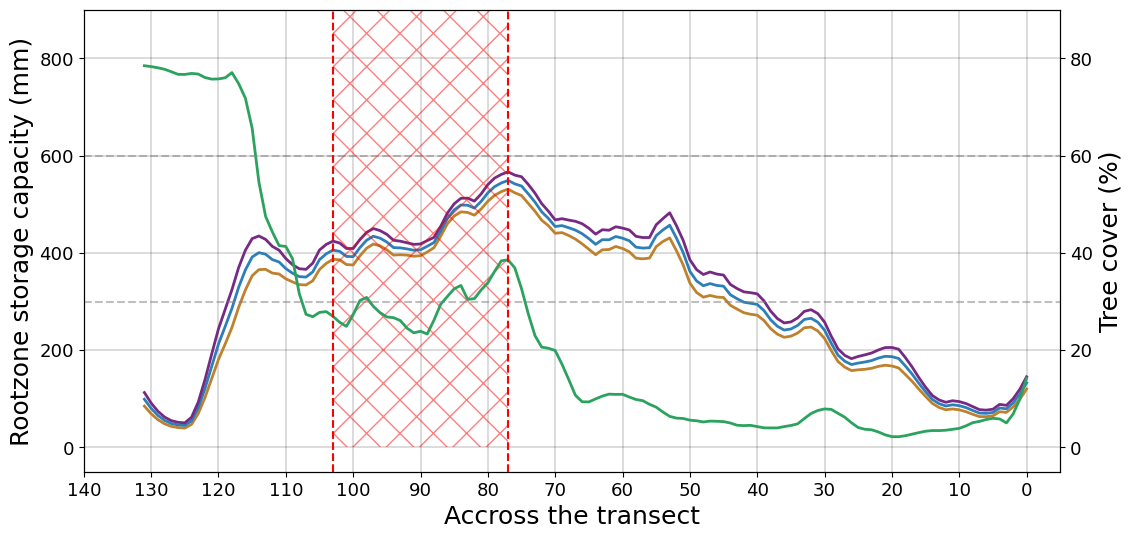

In [88]:
from scipy.signal import savgol_filter

fig, ax1 = plt.subplots(figsize = (12.6,6))
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

for return_period, color in zip([10,20,40], ['#bf812d','#2c7fb8', '#762a83']):
    S_r_yhat[str(return_period)] = savgol_filter(S_r_geometries_3[str(return_period)].mean(axis = 1), 7, 2)
    S_r_yhat[str(return_period)] = numpy_interpolater(S_r_yhat[str(return_period)])
    p1, = ax1.plot(S_r_yhat[str(return_period)], linewidth = 2, label = 'Rootzone Storage capacity (mm)', color = color)
    ax1.set_xlim(-5,S_r_yhat[str(return_period)].shape[0]-1+6)

Treecover_yhat = savgol_filter(Treecover_geometries_3[0:12].mean(axis = 0).mean(axis = 1), 7, 2) 
Treecover_yhat = numpy_interpolater(Treecover_yhat)

p2, = ax2.plot(Treecover_yhat, linewidth = 2, label = 'Treecover (%)', color = '#2ca25f')


ax1.set_xlabel('Accross the transect', fontsize = 18)
ax1.tick_params(axis='both', which='major', labelsize=13)
ax2.tick_params(axis='both', which='major', labelsize=13)
ax1.set_ylabel('Rootzone storage capacity (mm)', fontsize = 18)
ax2.set_ylabel('Tree cover (%)', fontsize = 18)
ax1.set_ylim(-50,900)

ax2.set_ylim(-5,90)

lines = [p1, p2]

#adds major gridlines
ax1.grid(color='black', linestyle='-', linewidth=0.25, alpha=0.8)
ax2.axhline(y=60, linestyle='--', color = 'grey', alpha = 0.5)
ax2.axhline(y=30, linestyle='--', color = 'grey', alpha = 0.5)
ax2.axvline(x=77, linestyle='--', color = 'r')
ax2.axvline(x=103, linestyle='--', color = 'r')
plt.fill_between([77,103],[900,900], facecolor="none", hatch="X", edgecolor="r", linewidth=0.0, alpha = 0.5)


major_ticks = np.arange(0, 150, 10)
ax1.set_xticks(major_ticks)
ax1.grid(color='black', linestyle='-', linewidth=0.25, alpha=0.8, which = 'major')
plt.gca().invert_xaxis()

##### Transect #6

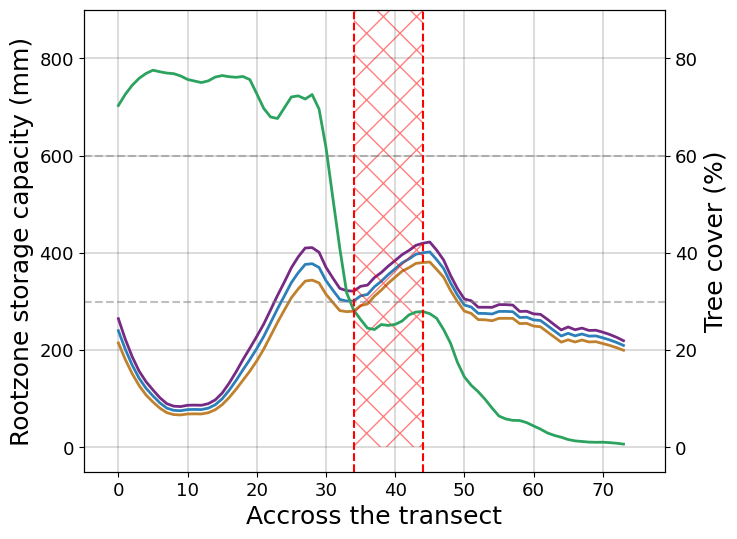

In [89]:
from scipy.signal import savgol_filter

fig, ax1 = plt.subplots(figsize = (7.5,6))
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

for return_period, color in zip([10,20,40], ['#bf812d','#2c7fb8', '#762a83']):
    S_r_yhat[str(return_period)] = savgol_filter(S_r_geometries_4[str(return_period)].mean(axis = 1), 7, 2)
    S_r_yhat[str(return_period)] = numpy_interpolater(S_r_yhat[str(return_period)])
    p1, = ax1.plot(S_r_yhat[str(return_period)], linewidth = 2, label = 'Rootzone Storage capacity (mm)', color = color)
    ax1.set_xlim(-5,S_r_yhat[str(return_period)].shape[0]-1+6)

Treecover_yhat = savgol_filter(Treecover_geometries_4[0:12].mean(axis = 0).mean(axis = 1), 7, 2) # window size 501, polynomial order 3
Treecover_yhat = numpy_interpolater(Treecover_yhat)

#ax3.spines["right"].set_position(("axes", 1.06))
#make_patch_spines_invisible(ax3)
# Second, show the right spine.
#ax3.spines["right"].set_visible(True)

p2, = ax2.plot(Treecover_yhat, linewidth = 2, label = 'Treecover (%)', color = '#2ca25f')

#ax1.yaxis.label.set_color(p1.get_color())
#ax1.yaxis.label.set_color(p1.get_color())
#ax2.yaxis.label.set_color(p2.get_color())
#ax3.yaxis.label.set_color(p3.get_color())

#Treecover_geometries_1[0].where(S_r_geometries_1.values).mean(axis = 0).plot(ax = ax2, color = 'g')
#Treecover_geometries_1[11].where(S_r_geometries_1.values).mean(axis = 0).plot(ax = ax2, color = 'r')
ax1.set_xlabel('Accross the transect', fontsize = 18)
ax1.tick_params(axis='both', which='major', labelsize=13)
ax2.tick_params(axis='both', which='major', labelsize=13)
ax1.set_ylabel('Rootzone storage capacity (mm)', fontsize = 18)
ax2.set_ylabel('Tree cover (%)', fontsize = 18)
ax1.set_ylim(-50,900)

ax2.set_ylim(-5,90)
#ax3.set_ylim(0,85)
lines = [p1, p2]

#adds major gridlines
ax1.grid(color='black', linestyle='-', linewidth=0.25, alpha=0.8)
ax2.axhline(y=60, linestyle='--', color = 'grey', alpha = 0.5)
ax2.axhline(y=30, linestyle='--', color = 'grey', alpha = 0.5)

ax2.axvline(x=44, linestyle='--', color = 'r')
ax2.axvline(x=34, linestyle='--', color = 'r')
plt.fill_between([34,44],[900,900], facecolor="none", hatch="X", edgecolor="r", linewidth=0.0, alpha = 0.5)
